# 1. Import libraries

In [1]:
%matplotlib inline

import pandas as pd 
import math
import matplotlib.pyplot as plt 
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from scipy.stats import mode

# 2. Change the working directory

In [2]:
os.chdir('/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts/')
os.getcwd()

'/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts'

# 3. Functions

In [3]:
#This function computes the intercept&slope from the reference beads, converts TOF to size and appends size to the original data
def compute_append_size(eg_data):
    bead_200 = pd.read_excel('../data/Drosophila_eggs_OD1_5_1xPBS_26-03-2021/Ref_bead_26-03-2021.xlsx', sheet_name='200 um Beads')
    bead_430 = pd.read_excel('../data/Drosophila_eggs_OD1_5_1xPBS_26-03-2021/Ref_bead_26-03-2021.xlsx', sheet_name='430 um Beads')
    
    bead_200_flt = bead_200[bead_200['TOF'] > 600]
    bead_430_flt = bead_430[bead_430['TOF'] > 1800]
    
    x = np.array([200]*95+ [430]*96).reshape((-1, 1))
    x.shape
    y = np.array(list(bead_200_flt['TOF'])+list(bead_430_flt['TOF']))
    y.shape
    
    model = LinearRegression().fit(x, y)    
    sl=model.coef_[0]
    intc =  model.intercept_    
    size = (eg_data['TOF'] - intc) / sl
    eg_data['Size'] = size
    return(eg_data)

#this function estimates the best bandwidth for smoothing kernel density of the provided dataset 
#it then fits guassian density kernel to the provided dataset 
def find_best_bandwidth(eg_data):    
    #convert the egg size data to numpy array
    eg = np.array(eg_data['Size'])
    #this is a default set of bandwidth to test
    bandwidths = 20 ** np.linspace(-1, 1, 20)
    #assess the scores of different bandwidth to find the best FROM the pre-defined set
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),{'bandwidth': bandwidths}, cv=KFold(n_splits=5, shuffle=True, random_state=2))
    grid.fit(eg[:, None]);
    #this is your best bandwidth
    best_bw = grid.best_params_['bandwidth']
    return best_bw

#this function specifies a polynomial function with 8 orders. 
#Source: https://stackoverflow.com/questions/48469889/how-to-fit-a-polynomial-with-some-of-the-coefficients-constrained
def func(x, a, b, c, d, e, f, g, h, i):
  return a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5 + g * x ** 6 + h * x ** 7+ i * x ** 8

#This function computes the area under a curve with a a polynomial function with 8 orders fit to it
def compute_area(x,coefs):
    area = sum(coefs[0] + coefs[1]*x + coefs[2]*x**2+ coefs[3]*x**3 + coefs[4]*x**4 +
               coefs[5]*x**5 + coefs[6]*x**6+ coefs[7]*x**7+ coefs[8]*x**8)
    return area
        
#This function extracts information (e.g. Ellipticalness index, EI, W: the highest recorded extinction by Biosorter for an object,
#L: the length of object, i.e. TOF, WL: the ratio of W to L which corresponds to the orientation of the elliptical object)
# The input data for this function are Biosorter output (the summary file and optical density).
def extract_optical_density(bio_data, opt_data):
    all_EI, all_W, all_L, all_WL = [], [], [], []
    #find the matching data in the 2 input files for each object using 'Id'
    for i in bio_data['Id']:
        #Each object has 4 optical density reading (each stored as a column in optical density file, we will 
        #only use the first one which corresponds to Extinction) 
        #remove zero values in the optical density data
        optden_nonzero = opt_data[str(i)][opt_data[str(i)]>0]    
        #if object is small, set all parameters to 0
        if len(optden_nonzero) <= 11:
            W, EI, L, WL = max(optden_nonzero), 0, 0,0
            all_EI.append(EI)
            all_W.append(W)
            all_L.append(L)
            all_WL.append(WL)   
        #if object is big compute parameters    
        if len(optden_nonzero) > 11:
            #L: corresponds to the recorded data for TOF
            L = len(optden_nonzero)
            #W: The Maximum recorded Extinction for an object
            W = max(optden_nonzero) - min(optden_nonzero)
            #Compute the Elliptical area using the estimated L and W. Note that it is divided by 2 because 
            #we will compare it with the area of an object under the optical density curve which is half an ellipse. 
            EllipArea = (math.pi*W*(L/2))/2
            #fit a curve to the optical density data
            X = np.linspace(0.5, L+0.5, L)
            ry = optden_nonzero - min(optden_nonzero)     
            popt_cons, popt_covar = curve_fit(func, X, ry)
            #compute the area under the optical density file
            Area = compute_area(X, popt_cons)
            #compute Ellipticalness index
            EI = Area/EllipArea  
            WL = W/L
            all_EI.append(EI)
            all_W.append(W)             
            all_L.append(L)
            all_WL.append(WL)
    return(all_EI, all_W, all_L, all_WL)   

#this function finds the border between egg debris/misaligned eggs and eggs.
#This function fits a guassian density kernel to data using the provided bandwidth. Assuming the data is bimodal,
#it then finds the first minimum point between the two modes which will be chosen as the border to separate modes
def find_border_KDE(eg_data, bw):
    #reshape the numpy array of egg size data
    egre = np.array(eg_data['Size'])[:, np.newaxis]
    #generate some data within the range of egg size
    egre_plot = np.linspace(0, 800, 1000)[:, np.newaxis]
    #Fit the Kernel Density model on the data.
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(egre)
    #Compute the log-likelihood of each sample under the model.
    log_dens = kde.score_samples(egre_plot) 
    #find the minima points in the dataset, i.e. the border between the two peaks
    #source: https://stackoverflow.com/questions/35094454/how-would-one-use-kernel-density-estimation-as-a-1d-clustering-method-in-scikit/35151947#35151947
    mi = argrelextrema(log_dens, np.less)[0] #(these are the y values, so their indices are the cut off for size)
    #plot the kernel density estimation
    fig, ax = plt.subplots(sharex=True, sharey=True)
    ax.plot(egre_plot[:, 0], np.exp(log_dens), color='maroon')
    #plot the border between the two peaks
    plt.vlines(x=egre_plot[mi][0], ymin=0, ymax=max(np.exp(log_dens)))
    plt.xlabel('Size')
    plt.ylabel('Density')           
    return egre_plot[mi][0][0]

#This function filters the Biosorter summary data using the estimated border
def remove_dust(eg_data, eg_bor):
    eg_data_flt = eg_data[eg_data['Size'] > eg_bor]
    return(eg_data_flt)

#this function is a compilation of multiple functions
#All the included functions are described above
def filter_dust_eggsize(eg_data):
    sam_bw = find_best_bandwidth(eg_data,)
    sam_bor = find_border_KDE(eg_data,sam_bw)
    sam_flt = remove_dust(eg_data, sam_bor)
    sam_flt_bw = find_best_bandwidth(sam_flt,)
    return (sam_flt,sam_flt_bw,sam_bor,sam_bw) #the order of output: filtered dataset, bandwidth of filtered dataset, border, bandwidth of unfiltered datset

#this function performs multiple filtering steps
#All the included functions are described above
#1. size, 2. EI, 3.W/L and 4. size
def filter_size_EI_WL_size(bio_data, opt_data):
    #remove columns that are not needed
    bio_data.drop(['Plate', 'Row', 'Column', 'Source well', 'Clog','PC Extinction',
                  'PC BFP','PC GFP','PC dsRED', 'Unnamed: 26'], inplace=True, axis=1)
    
    bio_data_sz = compute_append_size(bio_data)
    bio_data_sz['EI'],bio_data_sz['W'], bio_data_sz['L'], bio_data_sz['W/L']= extract_optical_density(bio_data_sz, opt_data)       
    bio_data_flt, bio_data_flt_bw, bio_data_bor, bio_data_bw = filter_dust_eggsize(bio_data_sz)
    
    #filter for the median of EI and W/L
    med_EI=np.median(bio_data_flt['EI'])
    std_EI=np.std(bio_data_flt['EI'])
    bio_data_flt2 = bio_data_flt[(bio_data_flt['EI'] >= med_EI-(std_EI/2)) & (bio_data_flt['EI'] <= med_EI+(std_EI/2))]
    
    med_WL=np.median(bio_data_flt['W/L'])
    std_WL=np.std(bio_data_flt['W/L'])
    bio_data_flt3 = bio_data_flt2[(bio_data_flt2['W/L'] >= med_WL-(std_WL/2)) & (bio_data_flt2['W/L'] <= med_WL+(std_WL/2))]
    
    bio_data_flt4, bio_data_flt_bw, bio_data_bor2, bio_data_bw = filter_dust_eggsize(bio_data_flt3)
    
    return(bio_data_flt,bio_data_flt2,bio_data_flt3,bio_data_flt4, bio_data_flt_bw, bio_data_bor, bio_data_bor2, bio_data_bw)

#this function does exactly similar as 'filter_size_EI_WL_size' for samples analyzed on 2 separate runs.
def filter_size_EI_WL_size_pool(bio_data1, opt_data1, bio_data2, opt_data2):
    bio_data1.drop(['Plate', 'Row', 'Column', 'Source well', 'Clog','PC Extinction',
                  'PC BFP','PC GFP','PC dsRED', 'Unnamed: 26'], inplace=True, axis=1)
    bio_data2.drop(['Plate', 'Row', 'Column', 'Source well', 'Clog','PC Extinction',
                  'PC BFP','PC GFP','PC dsRED', 'Unnamed: 26'], inplace=True, axis=1)
    
    bio_data1_sz = compute_append_size(bio_data1)
    bio_data1_sz['EI'],bio_data1_sz['W'],bio_data1_sz['L'], bio_data1_sz['W/L']= extract_optical_density(bio_data1_sz, opt_data1)       
    bio_data2_sz = compute_append_size(bio_data2)
    bio_data2_sz['EI'],bio_data2_sz['W'],bio_data2_sz['L'], bio_data2_sz['W/L']= extract_optical_density(bio_data2_sz, opt_data2)       

    bio_data_sz = pd.concat([bio_data1_sz,bio_data2_sz])
    bio_data_flt, bio_data_flt_bw, bio_data_bor, bio_data_bw = filter_dust_eggsize(bio_data_sz)
    
    med_EI=np.median(bio_data_flt['EI'])
    std_EI=np.std(bio_data_flt['EI'])
    bio_data_flt2 = bio_data_flt[(bio_data_flt['EI'] >= med_EI-(std_EI/2)) & (bio_data_flt['EI'] <= med_EI+(std_EI/2))]
    
    med_WL=np.median(bio_data_flt['W/L'])
    std_WL=np.std(bio_data_flt['W/L'])
    bio_data_flt3 = bio_data_flt2[(bio_data_flt2['W/L'] >= med_WL-(std_WL/2)) & (bio_data_flt2['W/L'] <= med_WL+(std_WL/2))]
    
    bio_data_flt4, bio_data_flt_bw, bio_data_bor2, bio_data_bw = filter_dust_eggsize(bio_data_flt3)
    
    return(bio_data_flt,bio_data_flt2,bio_data_flt3,bio_data_flt4, bio_data_flt_bw, bio_data_bor, bio_data_bor2, bio_data_bw)

# This function is to take the second element for sorting elements in a list
def takeSecond(elem):
    return elem[1]

#this function sets the color of fliers for boxplots
def set_color_flier(col):
    flierprops = dict( marker = '.',color = col, markerfacecolor = col, markeredgecolor = col, markersize =3)   
    return flierprops

#this function sets the color of boxes and whiskers for boxplots
def set_color_box(col):    
    colors=[ col] * 100
    fullset_color_box = colors
    fullset_color_whisker = [ col] * 80
    for patch, col in zip(box['boxes'], fullset_color_box):
        patch.set_facecolor(col)
        patch.set_edgecolor(col)
    for patch, col in zip(box['whiskers'], fullset_color_whisker):
        patch.set_color(col)
        patch.set_linestyle('-')

#this function sets the color of boxes and whiskers for boxplots based on 4 colors
def set_color_box_mod(): 
    colors=['indianred']*2+['limegreen']*1+['DarkGoldenrod']*1+['DarkTurquoise']*1+['salmon']*1
    fullset_color_box = colors
    fullset_color_whisker = ['indianred']*4+['limegreen']*2+['DarkGoldenrod']*2+['DarkTurquoise']*2+['salmon']*2
    for patch, col in zip(box['boxes'], fullset_color_box):
        patch.set_facecolor(col)
        patch.set_edgecolor(col)
    for patch, col in zip(box['whiskers'], fullset_color_whisker):
        patch.set_color(col)
        patch.set_linestyle('-')

#this function uses the provided threhsolds (as a list) to filter datasets (as a list) and computes some summary statistics for the datasets
#this function filters the raw data using the threshold determined by the first size filtering to determine the nonegg objects
#this function also filters the dataset filtered for EI and W/L based on the threshold determined by the last size filtering
def filter_compute_summary_stat(rawdata, data_flt3, thresh, thresh2):
    num_nonegg, mean_nonegg,median_nonegg,num_egg, mean_egg,median_egg = [],[],[],[],[],[]
    for ind,item in enumerate(rawdata):
        tmp_nonegg = item[item['Size'] <= thresh[ind]]
        tmp_egg = data_flt3[ind][data_flt3[ind]['Size'] > thresh2[ind]]
        #'num_nonegg', 'mean_nonegg','median_nonegg','num_egg', 'mean_egg','median_egg'
        num_nonegg.append(len(tmp_nonegg))
        mean_nonegg.append(np.mean(tmp_nonegg['Size']))
        median_nonegg.append(np.median(tmp_nonegg['Size']))
        num_egg.append(len(tmp_egg))
        mean_egg.append(np.mean(tmp_egg['Size']))
        median_egg.append(np.median(tmp_egg['Size']))
    return([num_nonegg,mean_nonegg,median_nonegg,num_egg,mean_egg,median_egg]) 

#This function computes summary statistics of nonegg objects, and misaligned eggs and final egg dataset
def compute_summary_stat(rawdata, data_flt, data_flt4):
    num_egg,num_nonegg, num_mis_egg, mode_nonegg, mean_nonegg, median_nonegg,mode_egg,mean_egg, median_egg, mean_mis_egg,median_mis_egg = [],[],[],[],[],[],[],[],[],[],[]
    for ind,item in enumerate(rawdata):       
        data_noegg = pd.concat([data_flt[ind],item]).drop_duplicates(keep=False)
        data_missegg = pd.concat([data_flt[ind],data_flt4[ind]]).drop_duplicates(keep=False)
        #'num_egg', 'num_nonegg', 'num_misaligned_egg', 'mode_nonegg', 'mean_nonegg', 'median_nonegg', 'mode_egg', 
        #'mean_egg', 'median_egg', 'mean_misaligned_egg', 'median_misaligned_egg'
        num_egg.append(len(data_flt4[ind]))
        num_nonegg.append(len(data_noegg))
        num_mis_egg.append(len(data_missegg))
        mode_nonegg.append(mode(data_noegg['Size'])[0][0])
        mean_nonegg.append(np.mean(data_noegg['Size']))
        median_nonegg.append(np.median(data_noegg['Size']))
        mode_egg.append(mode(data_flt4[ind]['Size'])[0][0])
        mean_egg.append(np.mean(data_flt4[ind]['Size']))
        median_egg.append(np.median(data_flt4[ind]['Size']))
        mean_mis_egg.append(np.mean(data_missegg['Size']))
        median_mis_egg .append(np.median(data_missegg['Size']))
    return([num_egg,num_nonegg, num_mis_egg, mode_nonegg, mean_nonegg, median_nonegg,mode_egg,mean_egg, median_egg, mean_mis_egg,median_mis_egg])

#this function computes the speed of measurement
def compute_speed(data):
    #determine the number of objects in a dataset
    obj_num = len(data)
    #compute measurement time, the time is in millisecond so it will be converted to minute
    msr_time= (max(data['Time'].astype(int))-min(data['Time'].astype(int)))/60000
    return(obj_num, msr_time, obj_num/msr_time)




# 4. The size distribution of *Drosophila* inbred lines

## 4.1 Input files

### 4.1.1. The first file is Biosorter output that contains information about TOF, Extinction and fluorescence absorbance (summary file).


In [4]:
#D. simulans samples
Dsim001 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim001.txt')
Dsim004 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim004.txt')
Dsim11 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim11.txt')
Dsim75 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim75.txt')
Dsim90 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.sim90.txt')
Dsim91 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim91.txt')
Dsim146 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim146.txt')
Dsim166 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim166.txt')
Dsim185 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim185.txt')
Dsim196 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim196.txt')
 
#D. melanogaster
Lausanne5 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/Lausanne5.txt')

#D. erecta
Dere01 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.ere01.txt')

#D. santomea
Dsan01 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.san01.txt')


### We have shown in *duplicate_runs Jjupyter notebook* that the estimated size distribution for samples ran on different Biosorter runs are comparable and can be pooled. 

In [5]:
#for datasets with 2 runs, we will pool 
#D. simulans
Dsim5_1 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim5.txt')
Dsim5_2 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.sim5.txt')

Dsim237_1 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim237.txt')
Dsim237_2 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.sim237.txt')

#D. mauritiana
Dmau151_1 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.mau151.txt')
Dmau151_2 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.mau151.txt')


### We remove rows at the end of the file about specifications of each run that are not needed.

In [6]:
Dsim001=Dsim001.drop(Dsim001.index[3920:])
Dsim004=Dsim004.drop(Dsim004.index[13259:])
Dsim11=Dsim11.drop(Dsim11.index[3199:])
Dsim75=Dsim75.drop(Dsim75.index[7029:])
Dsim90=Dsim90.drop(Dsim90.index[6135:])
Dsim91=Dsim91.drop(Dsim91.index[17675:])
Dsim146=Dsim146.drop(Dsim146.index[10324:])
Dsim166=Dsim166.drop(Dsim166.index[7174:])
Dsim185=Dsim185.drop(Dsim185.index[17826:])
Dsim196=Dsim196.drop(Dsim196.index[18258:])

#duplicate runs
Dsim5_1=Dsim5_1.drop(Dsim5_1.index[837:])
Dsim5_2=Dsim5_2.drop(Dsim5_2.index[1044:])

Dsim237_1=Dsim237_1.drop(Dsim237_1.index[1497:])
Dsim237_2=Dsim237_2.drop(Dsim237_2.index[4797:])

Dmau151_1=Dmau151_1.drop(Dmau151_1.index[6869:])
Dmau151_2=Dmau151_2.drop(Dmau151_2.index[17749:])

Lausanne5=Lausanne5.drop(Lausanne5.index[7159:])
Dere01=Dere01.drop(Dere01.index[8266:])
Dsan01=Dsan01.drop(Dsan01.index[3348:])


### 4.1.2. The second file contains the optical density data

### This file contains columns that correspond to each object in the summary file. Each object has 4 corresponding columns. We only need the first one which corresponds to Extinction, the other 3 correspond to 3 fluorescence laser.

In [7]:
Dsim001_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim001_prf.txt')
Dsim004_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim004_prf.txt')
Dsim11_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim11_prf.txt')
Dsim75_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim75_prf.txt')
Dsim90_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.sim90_prf.txt')
Dsim91_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim91_prf.txt')
Dsim146_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim146_prf.txt')
Dsim166_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim166_prf.txt')
Dsim185_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim185_prf.txt')
Dsim196_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim196_prf.txt')

#for datasets with 2 runs, we will pool 
Dsim5_opt_1 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim5_prf.txt')
Dsim5_opt_2 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.sim5_prf.txt')

Dsim237_opt_1 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.sim237_prf.txt')
Dsim237_opt_2 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.sim237_prf.txt')

Dmau151_opt_1 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.mau151_prf.txt')
Dmau151_opt_2 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.mau151_prf.txt')

Lausanne5_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/Lausanne5_prf.txt')
Dere01_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_22-12-2021/D.ere01_prf.txt')
Dsan01_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_21-12-2021/D.san01_prf.txt')


## 4.2 filtering the egg size datasets

### We filter the egg size distribution based on size (corresponding to small non-egg objects) and elipticalness index (EI) and W/L corresponding to misaligned eggs. The filtering for each dataset generated 2 plots: the first plot is the size distribution before the initial filtering based on size. The vertical blue line shows the border that is used for filtering small objects. The second plot shows the size distribution after EI and W/L filtering and before the final size filtering. The vertical blue line is used to filter small objects. 

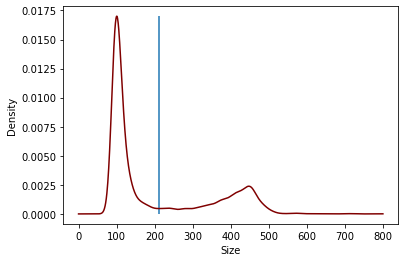

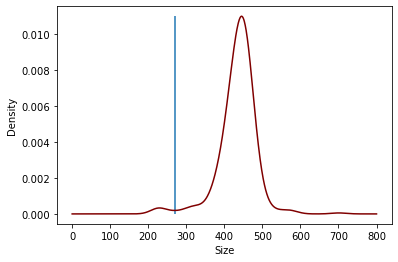

In [8]:
Dsim001_flt,Dsim001_flt2,Dsim001_flt3,Dsim001_flt4, Dsim001_flt_bw, Dsim001_bor, Dsim001_bor2, Dsim001_bw = filter_size_EI_WL_size(Dsim001,Dsim001_opt)


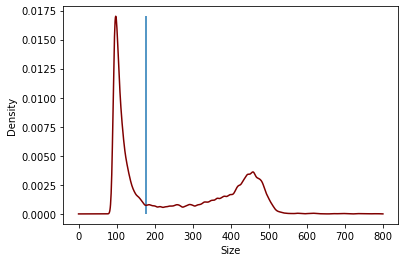

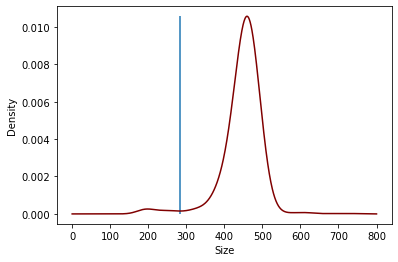

In [9]:
Dsim004_flt,Dsim004_flt2,Dsim004_flt3,Dsim004_flt4, Dsim004_flt_bw, Dsim004_bor, Dsim004_bor2, Dsim004_bw = filter_size_EI_WL_size(Dsim004,Dsim004_opt)


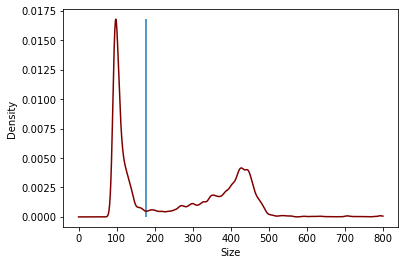

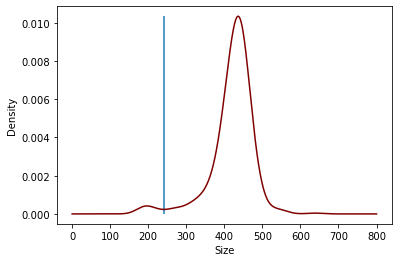

In [10]:
Dsim11_flt,Dsim11_flt2,Dsim11_flt3,Dsim11_flt4, Dsim11_flt_bw, Dsim11_bor, Dsim11_bor2, Dsim11_bw = filter_size_EI_WL_size(Dsim11,Dsim11_opt)


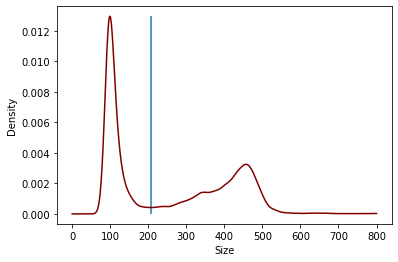

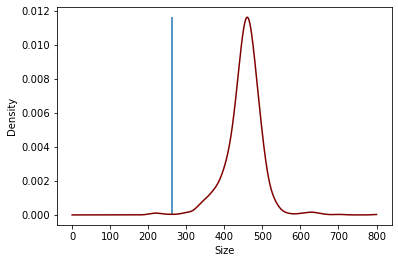

In [11]:
Dsim75_flt,Dsim75_flt2,Dsim75_flt3,Dsim75_flt4, Dsim75_flt_bw, Dsim75_bor, Dsim75_bor2, Dsim75_bw = filter_size_EI_WL_size(Dsim75,Dsim75_opt)


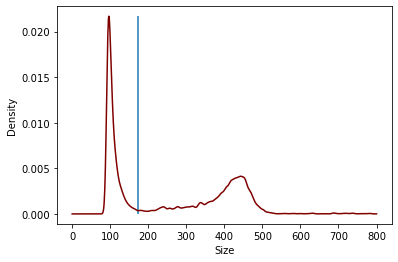

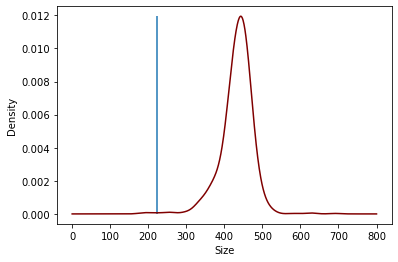

In [12]:
Dsim90_flt,Dsim90_flt2,Dsim90_flt3,Dsim90_flt4, Dsim90_flt_bw, Dsim90_bor, Dsim90_bor2,Dsim90_bw = filter_size_EI_WL_size(Dsim90,Dsim90_opt)


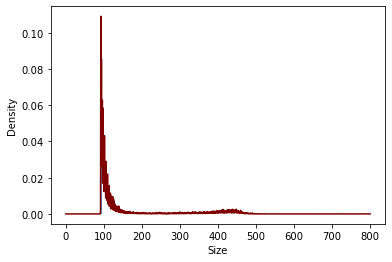

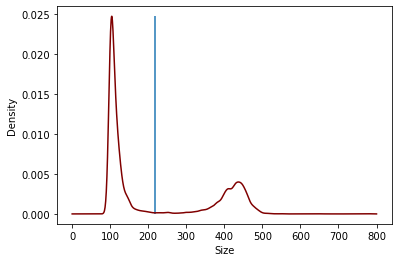

In [13]:
Dsim91_flt,Dsim91_flt2,Dsim91_flt3,Dsim91_flt4, Dsim91_flt_bw, Dsim91_bor, Dsim91_bor2, Dsim91_bw = filter_size_EI_WL_size(Dsim91,Dsim91_opt)


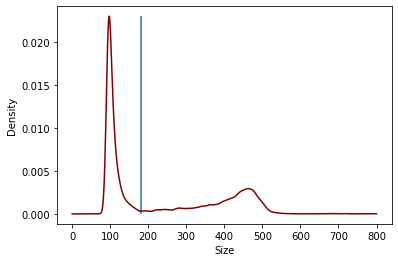

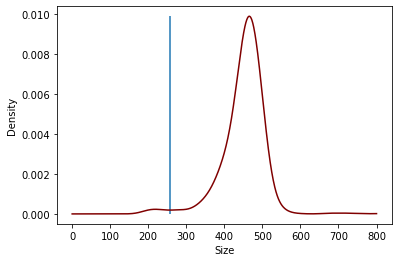

In [14]:
Dsim146_flt,Dsim146_flt2,Dsim146_flt3,Dsim146_flt4, Dsim146_flt_bw, Dsim146_bor, Dsim146_bor2, Dsim146_bw = filter_size_EI_WL_size(Dsim146,Dsim146_opt)


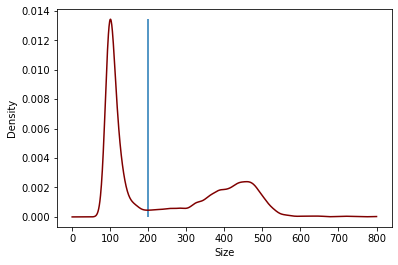

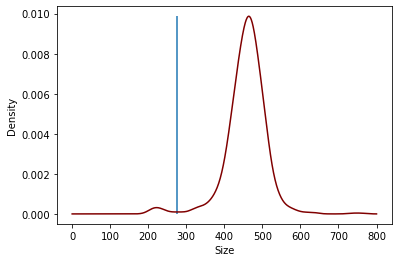

In [15]:
Dsim166_flt,Dsim166_flt2,Dsim166_flt3,Dsim166_flt4, Dsim166_flt_bw, Dsim166_bor, Dsim166_bor2,Dsim166_bw = filter_size_EI_WL_size(Dsim166,Dsim166_opt)


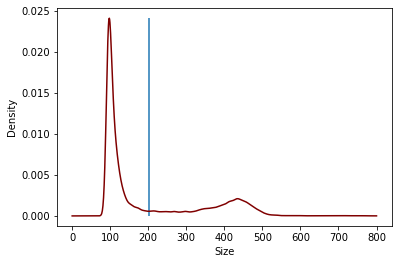

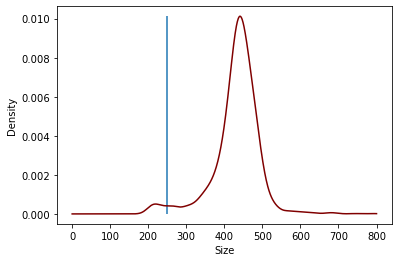

In [16]:
Dsim185_flt,Dsim185_flt2,Dsim185_flt3,Dsim185_flt4, Dsim185_flt_bw, Dsim185_bor, Dsim185_bor2,Dsim185_bw = filter_size_EI_WL_size(Dsim185,Dsim185_opt)


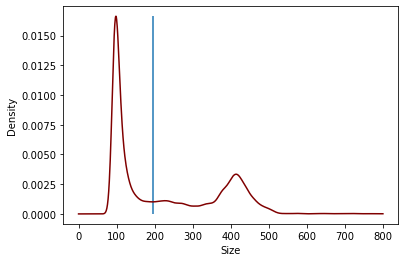

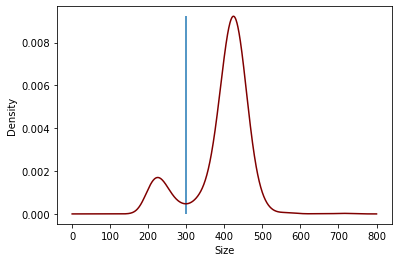

In [17]:
Dsim196_flt,Dsim196_flt2,Dsim196_flt3,Dsim196_flt4, Dsim196_flt_bw, Dsim196_bor, Dsim196_bor2, Dsim196_bw = filter_size_EI_WL_size(Dsim196,Dsim196_opt)


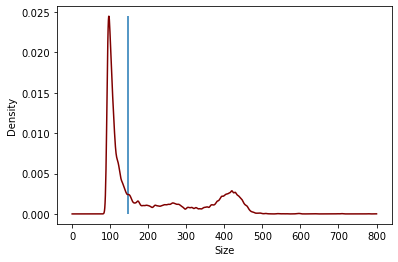

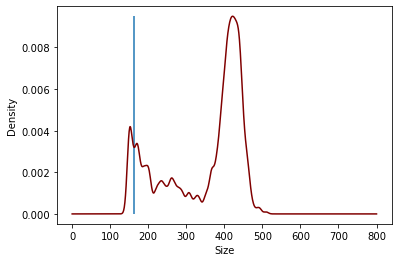

In [18]:
Lausanne5_flt,Lausanne5_flt2,Lausanne5_flt3,Lausanne5_flt4, Lausanne5_flt_bw, Lausanne5_bor,Lausanne5_bor2, Lausanne5_bw = filter_size_EI_WL_size(Lausanne5,Lausanne5_opt)


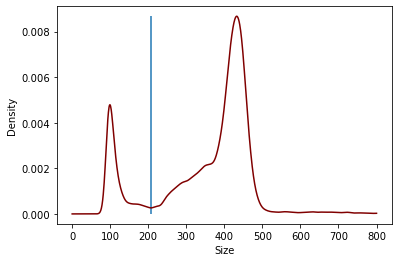

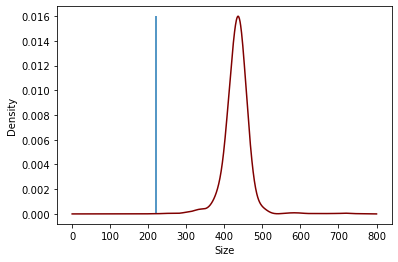

In [19]:
Dere01_flt,Dere01_flt2,Dere01_flt3,Dere01_flt4, Dere01_flt_bw, Dere01_bor, Dere01_bor2, Dere01_bw = filter_size_EI_WL_size(Dere01,Dere01_opt)


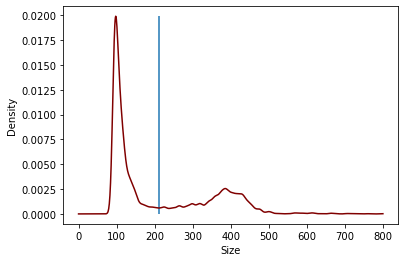

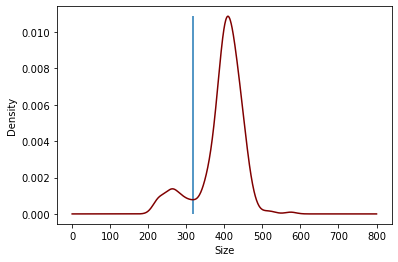

In [20]:
Dsan01_flt,Dsan01_flt2,Dsan01_flt3,Dsan01_flt4, Dsan01_flt_bw, Dsan01_bor,Dsan01_bor2, Dsan01_bw = filter_size_EI_WL_size(Dsan01,Dsan01_opt)


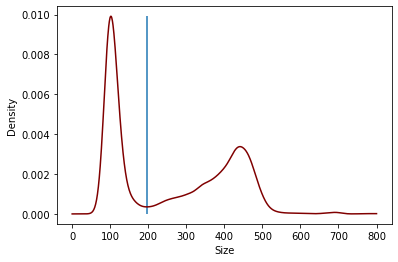

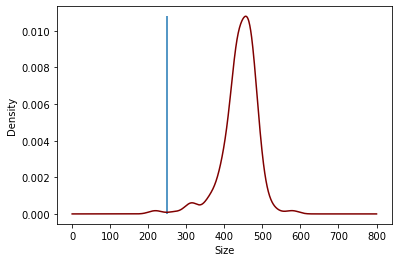

In [21]:
Dsim5_flt,Dsim5_flt2,Dsim5_flt3,Dsim5_flt4, Dsim5_flt_bw, Dsim5_bor,Dsim5_bor2, Dsim5_bw = filter_size_EI_WL_size_pool(Dsim5_1, Dsim5_opt_1, Dsim5_2, Dsim5_opt_2)


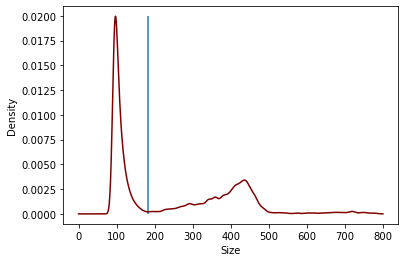

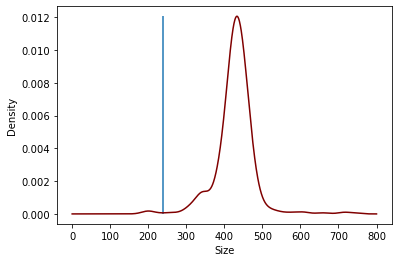

In [22]:
Dsim237_flt,Dsim237_flt2,Dsim237_flt3,Dsim237_flt4, Dsim237_flt_bw, Dsim237_bor, Dsim237_bor2, Dsim237_bw = filter_size_EI_WL_size_pool(Dsim237_1, Dsim237_opt_1, Dsim237_2, Dsim237_opt_2)


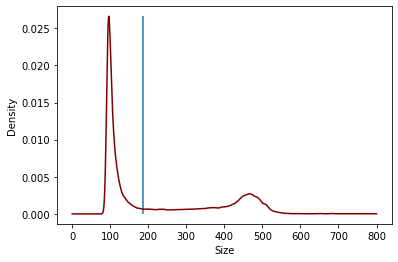

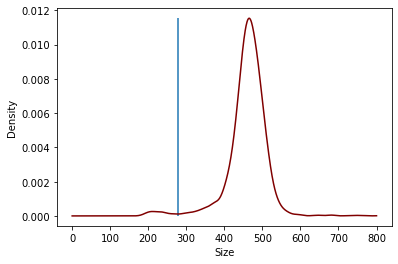

In [23]:
Dmau151_flt,Dmau151_flt2,Dmau151_flt3,Dmau151_flt4, Dmau151_flt_bw, Dmau151_bor, Dmau151_bor2, Dmau151_bw = filter_size_EI_WL_size_pool(Dmau151_1, Dmau151_opt_1, Dmau151_2, Dmau151_opt_2)


## 4.3 Visualization of filtered egg size distributions

### 4.3.1 Size thresholds

### We check the determined borders for filtering small objects in all datasets


In [24]:
all_bor = [Dsim001_bor,Dsim004_bor,Dsim5_bor, Dsim11_bor,Dsim75_bor,Dsim90_bor,Dsim91_bor,Dsim146_bor,
               Dsim166_bor,Dsim185_bor,Dsim196_bor,Dsim237_bor,Lausanne5_bor,Dere01_bor,Dsan01_bor,Dmau151_bor]

Text(0, 0.5, 'Count')

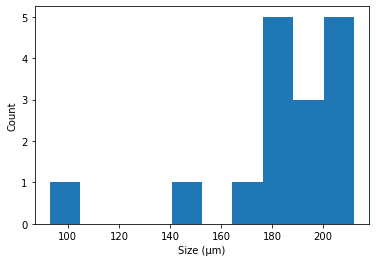

In [25]:
plt.hist(all_bor)
plt.xlabel('Size (μm)')
plt.ylabel('Count') 

### We compute the statistics for sample-specific thresholds

In [26]:
print(np.mean(all_bor), np.median(all_bor), np.var(all_bor), np.std(all_bor))

184.2842842842843 190.990990990991 834.4580817053289 28.886988103735025


### We check the determined borders for filtering misaligned eggs in all datasets

In [27]:
all_bor2 = [Dsim001_bor2,Dsim004_bor2,Dsim5_bor2, Dsim11_bor2,Dsim75_bor2,Dsim90_bor2,Dsim91_bor2,Dsim146_bor2,
               Dsim166_bor2,Dsim185_bor2,Dsim196_bor2,Dsim237_bor2,Lausanne5_bor2,Dere01_bor2,Dsan01_bor2,Dmau151_bor2]

Text(0, 0.5, 'Count')

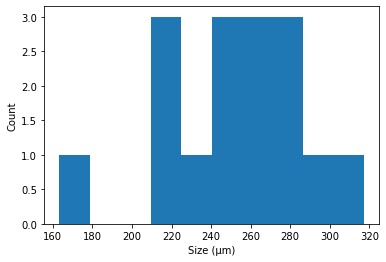

In [28]:
plt.hist(all_bor2)
plt.xlabel('Size (μm)')
plt.ylabel('Count')

In [29]:
print(np.mean(all_bor2), np.median(all_bor2), np.var(all_bor2), np.std(all_bor2))

252.55255255255258 252.65265265265268 1266.9225782338897 35.59385590567408


### 4.3.2 Egg size distribution

### *D. simulans* inbred lines

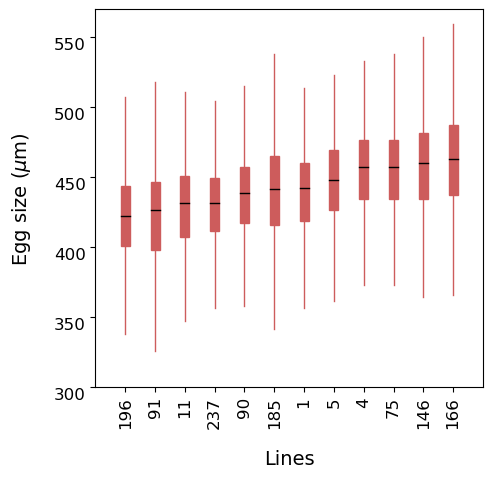

In [30]:
#make a list of all D. simulans samples
sim_eg_data = [Dsim001_flt4,Dsim004_flt4,Dsim5_flt4, Dsim11_flt4,Dsim75_flt4,Dsim90_flt4,Dsim91_flt4,Dsim146_flt4,
               Dsim166_flt4, Dsim185_flt4,Dsim196_flt4,Dsim237_flt4]
labels = ['1','4','5','11','75','90','91','146','166','185','196','237']

#sort datasets based on the median size (in increasing order)
all_eg_data_srt = [(ind,np.median(i['Size'])) for ind,i in enumerate(sim_eg_data)]
all_eg_data_srt.sort(key=takeSecond)

labels_srt = [labels[i[0]] for i in all_eg_data_srt]

#now we make boxplots
fig , ax = plt.subplots(sharex=True, sharey=True,figsize=(5,5),dpi=100, facecolor='w', edgecolor='k')
set_color_flier('indianred')
box=ax.boxplot([sim_eg_data[i[0]]['Size'] for i in all_eg_data_srt], widths= 0.3, medianprops = dict(color="black",linewidth=1), vert = True,showcaps = False, showfliers = False, patch_artist=True, flierprops=set_color_flier('indianred'))
set_color_box('indianred')
plt.xlim(0,len(all_eg_data_srt)+1)   
plt.ylim(300, 570)
plt.xticks(np.arange(1,len(all_eg_data_srt)+1,1),labels_srt,fontsize=12, va='top',rotation=90)
plt.yticks(fontsize=12, va='top')
plt.xlabel('Lines', size = 14,labelpad=15)
plt.ylabel(r'Egg size ($\mu$m)', size = 14,labelpad=15)
plt.savefig('../plots/final_plots/boxplot_dist_Dsim.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/boxplot_dist_Dsim.svg', dpi=100,format='svg', bbox_inches = 'tight')



### *Drosophila* inbred lines

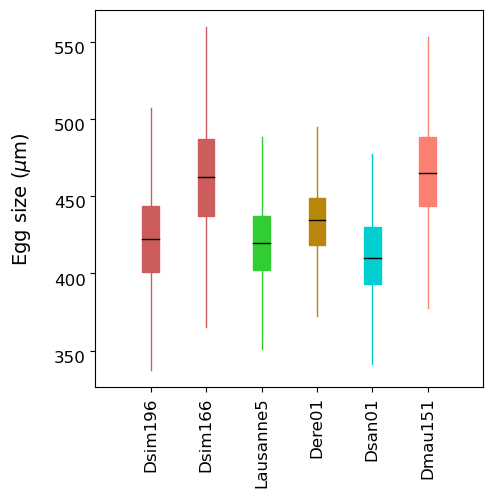

In [31]:
#make a list of all samples
D_eg_data = [Dsim196_flt4,Dsim166_flt4,Lausanne5_flt4[Lausanne5_flt4['Size'] >= 350],Dere01_flt4,Dsan01_flt4,Dmau151_flt4]
labels = ['Dsim196','Dsim166','Lausanne5','Dere01','Dsan01','Dmau151']

#now we make boxplots
fig , ax = plt.subplots(sharex=True, sharey=True,figsize=(5,5),dpi=100, facecolor='w', edgecolor='k')
box=ax.boxplot([i['Size'] for i in D_eg_data], widths= 0.3, medianprops = dict(color="black",linewidth=1), vert = True,showcaps = False, showfliers = False, patch_artist=True, flierprops=set_color_flier('indianred'))
set_color_box_mod()
plt.xlim(0,len(D_eg_data)+1)   
#plt.ylim(150, 650)
plt.xticks(np.arange(1,len(D_eg_data)+1,1),labels,fontsize=12, va='top',rotation=90)
plt.yticks(fontsize=12, va='top')
plt.ylabel(r'Egg size ($\mu$m)', size = 14,labelpad=15)
plt.savefig('../plots/final_plots/boxplot_dist_allDros.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/boxplot_dist_allDros.svg', dpi=100,format='svg', bbox_inches = 'tight')


## 4.4 Comparison of egg size distributions based on filtering thresholds

### We compute the mode of 1st and 2nd peaks in the bimodal egg size distribution


In [32]:
#sample names
sam = ['Dsim1','Dsim4','Dsim5','Dsim11','Dsim75','Dsim90','Dsim91','Dsim146','Dsim166','Dsim185','Dsim196','Dsim237',
       'Lausanne5','Dere01','Dsan01','Dmau151']

Dsim5 = pd.concat([Dsim5_1,Dsim5_2])
Dsim237 = pd.concat([Dsim237_1,Dsim237_2])
Dmau151 = pd.concat([Dmau151_1,Dmau151_2])

#a list of original not-filtered data
sam_rawdata = [Dsim001,Dsim004,Dsim5, Dsim11,Dsim75,Dsim90,Dsim91,Dsim146,
               Dsim166,Dsim185,Dsim196,Dsim237,Lausanne5,Dere01,Dsan01,Dmau151]

#a list of all filtered data - after initial size filtering
sam_flt = [Dsim001_flt,Dsim004_flt,Dsim5_flt, Dsim11_flt,Dsim75_flt,Dsim90_flt,Dsim91_flt,Dsim146_flt,
               Dsim166_flt,Dsim185_flt,Dsim196_flt,Dsim237_flt,Lausanne5_flt,Dere01_flt,Dsan01_flt,Dmau151_flt]

#a list of all filtered data - after EI and W/L filtering
sam_flt3 = [Dsim001_flt3,Dsim004_flt3,Dsim5_flt3, Dsim11_flt3,Dsim75_flt3,Dsim90_flt3,Dsim91_flt3,Dsim146_flt3,
               Dsim166_flt3,Dsim185_flt3,Dsim196_flt3,Dsim237_flt3,Lausanne5_flt3,Dere01_flt3,Dsan01_flt3,Dmau151_flt3]

#a list of all filtered data - final step
sam_flt4 = [Dsim001_flt4,Dsim004_flt4,Dsim5_flt4, Dsim11_flt4,Dsim75_flt4,Dsim90_flt4,Dsim91_flt4,Dsim146_flt4,
               Dsim166_flt4,Dsim185_flt4,Dsim196_flt4,Dsim237_flt4,Lausanne5_flt4,Dere01_flt4,Dsan01_flt4,Dmau151_flt4]

#a list of all borders between two peaks in the 1st step of filtering
sam_thre = [Dsim001_bor,Dsim004_bor,Dsim5_bor, Dsim11_bor,Dsim75_bor,Dsim90_bor,Dsim91_bor,Dsim146_bor,
               Dsim166_bor,Dsim185_bor,Dsim196_bor,Dsim237_bor,Lausanne5_bor,Dere01_bor,Dsan01_bor,Dmau151_bor]

#a list of all borders between two peaks in the 4th step of filtering
sam_thre2 = [Dsim001_bor2,Dsim004_bor2,Dsim5_bor2, Dsim11_bor2,Dsim75_bor2,Dsim90_bor2,Dsim91_bor2,Dsim146_bor2,
               Dsim166_bor2,Dsim185_bor2,Dsim196_bor2,Dsim237_bor2,Lausanne5_bor2,Dere01_bor2,Dsan01_bor2,Dmau151_bor2]


In [34]:
ss_all = compute_summary_stat(sam_rawdata, sam_flt, sam_flt4)

### We save the first and second modes of egg size distributions in a file.

In [47]:
#write the result in table
OutputFile = open('../plots/final_plots/mode_border.txt','w')

OutputFile.write('Sample'+'\t'+'1st peak mode'+'\t'+ 'size threshold'+'\t'+'2nd peak mode'+'\n')
for i in range(len(sam_rawdata)):
    OutputFile.write(str(sam[i])+'\t'+str(np.round(ss_all[3][i],3))+'\t'+str(np.round(sam_thre[i],3))+'\t'+str(np.round(mode(sam_flt[i]['Size'])[0][0],3)) +'\n')
OutputFile.flush()


### We compute summary statistics for each dataset by filtering using both a sample-specific threhsold and a constant threshold computed as the average threshold across all datasets.

In [48]:
#compute summary statistics for datasets by filtering them using sample specific threhsold
num_nonegg_ss,mean_nonegg_ss,median_nonegg_ss,num_egg_ss,mean_egg_ss,median_egg_ss = filter_compute_summary_stat(sam_rawdata,sam_flt3, sam_thre,sam_thre2)
#compute summary statistics for datasets by filtering them using average of sample specific threhsold
num_nonegg_ave,mean_nonegg_ave,median_nonegg_ave,num_egg_ave,mean_egg_ave,median_egg_ave = filter_compute_summary_stat(sam_rawdata,sam_flt3,[np.round(np.mean(sam_thre),3)]*len(sam_thre), [np.round(np.mean(sam_thre2),3)]*len(sam_thre2))



### We check the correlation between the number of nonegg objects, and the mean and median of their sizes between datasets filtered using sample-specific threhsold and a constant threshold computed as the average threshold across all datasets.

In [49]:
print(spearmanr(num_nonegg_ss, num_nonegg_ave))
print(spearmanr(mean_nonegg_ss, mean_nonegg_ave))
print(spearmanr(median_nonegg_ss, median_nonegg_ave))

SpearmanrResult(correlation=0.8058823529411765, pvalue=0.00016384666473672616)
SpearmanrResult(correlation=0.7764705882352941, pvalue=0.0004043508405454705)
SpearmanrResult(correlation=0.8635891777897466, pvalue=1.6306335112679616e-05)


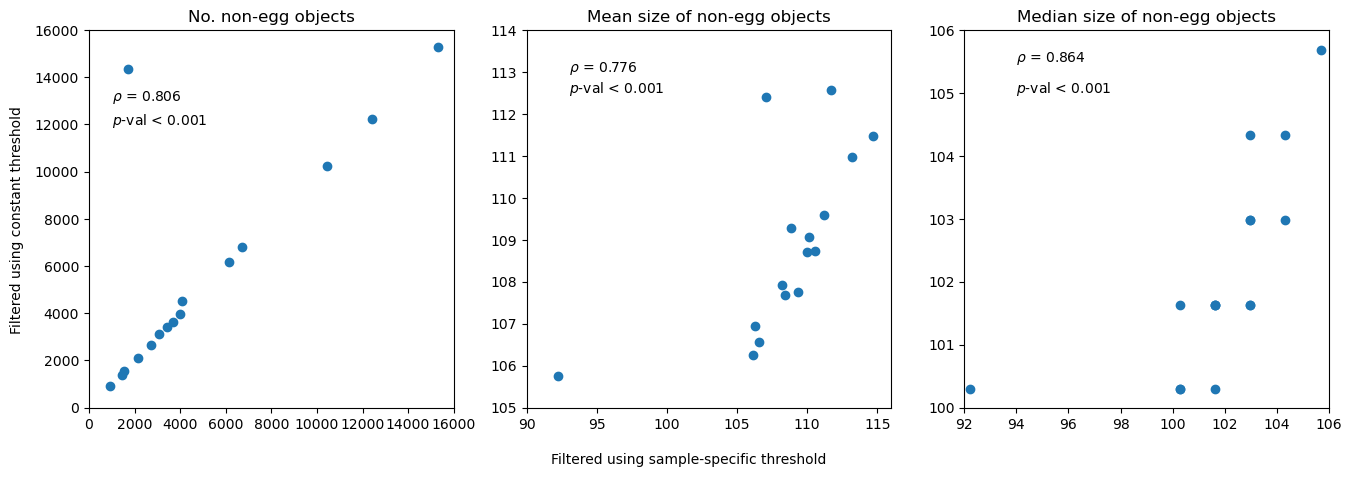

In [50]:
fig , ax = plt.subplots(nrows=1, ncols=3,sharex=True, sharey=True,figsize=(16,5),dpi=100, facecolor='w', edgecolor='k')    
ax=plt.subplot(1,3,1)
plt.title('No. non-egg objects')
plt.plot(num_nonegg_ss, num_nonegg_ave, marker = 'o', linestyle = '')
plt.xlim(0,16000)
plt.ylim(0,16000)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(num_nonegg_ss, num_nonegg_ave)[0],3)), xy=(1000,13000))
plt.annotate('$\it{p}$-val < 0.001', xy=(1000,12000))
ax=plt.subplot(1,3,2)
plt.title('Mean size of non-egg objects')
plt.plot(mean_nonegg_ss, mean_nonegg_ave, marker = 'o', linestyle = '')
plt.xlim(90,116)
plt.ylim(105,114)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(mean_nonegg_ss, mean_nonegg_ave)[0],3)), xy=(93,113))
plt.annotate('$\it{p}$-val < 0.001', xy=(93,112.5))
ax=plt.subplot(1,3,3)
plt.title('Median size of non-egg objects')
plt.plot(median_nonegg_ss, median_nonegg_ave, marker = 'o', linestyle = '')
plt.xlim(92,106)
plt.ylim(100,106)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(median_nonegg_ss, median_nonegg_ave)[0],3)), xy=(94,105.5))
plt.annotate('$\it{p}$-val < 0.001', xy=(94,105))
fig.text(0.5, 0.02, 'Filtered using sample-specific threshold', ha='center', va='center')
fig.text(0.08, 0.5, 'Filtered using constant threshold', ha='center', va='center', rotation='vertical')
plt.savefig('../plots/final_plots/stats_nonegg_particles.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/stats_nonegg_particles.svg', dpi=100,format='svg', bbox_inches = 'tight')


### The above plot shows that there is a good correlation between filtered data using either sample-specific or average of sample-specific thresholds.


### We check whether the number of non-egg objects is related to the number of eggs (the sum of properly and misaligned eggs).

In [74]:
spearmanr([i+ss_all[2][ind] for ind,i in enumerate(ss_all[0])] , ss_all[1])

SpearmanrResult(correlation=0.5058823529411764, pvalue=0.045581616123940336)

Text(0, 0.5, 'No. non-egg particles')

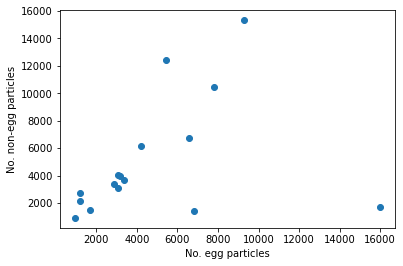

In [75]:
plt.scatter([i+ss_all[2][ind] for ind,i in enumerate(ss_all[0])] , ss_all[1])
plt.xlabel('No. egg particles')
plt.ylabel('No. non-egg particles')


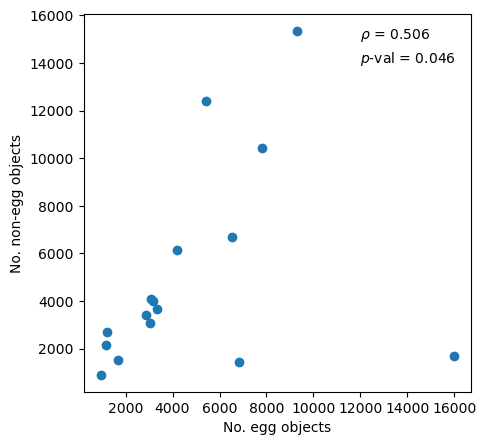

In [80]:
fig , ax = plt.subplots(sharex=True, sharey=True,figsize=(5,5),dpi=100, facecolor='w', edgecolor='k')    
plt.scatter([i+ss_all[2][ind] for ind,i in enumerate(ss_all[0])] , ss_all[1])
plt.ylabel('No. non-egg objects')
plt.xlabel('No. egg objects')
plt.annotate(r'$\rho$ = %.3f'%(spearmanr([i+ss_all[2][ind] for ind,i in enumerate(ss_all[0])] , ss_all[1])[0]), xy=(12000,15000))
plt.annotate(r'$\it{p}$-val = %.3f'%(spearmanr([i+ss_all[2][ind] for ind,i in enumerate(ss_all[0])] , ss_all[1])[1]), xy=(12000,14000))
plt.savefig('../plots/final_plots/egg_nonegg_particles_cor_sample_specific_threshold.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/egg_nonegg_particles_cor_sample_specific_threshold.svg', dpi=100,format='svg', bbox_inches = 'tight')


### so it seems that the more eggs in a sample the higher number of non-egg particles probably because these non-egg particles are the result of crushed eggs

In [54]:
print(spearmanr(num_egg_ss,num_egg_ave))
print(spearmanr(mean_egg_ss,mean_egg_ave))
print(spearmanr(median_egg_ss,median_egg_ave))

SpearmanrResult(correlation=0.9970588235294118, pvalue=5.0655883449921147e-17)
SpearmanrResult(correlation=0.9941176470588234, pvalue=6.4339974884469385e-15)
SpearmanrResult(correlation=0.9970501474926252, pvalue=5.170999826449611e-17)


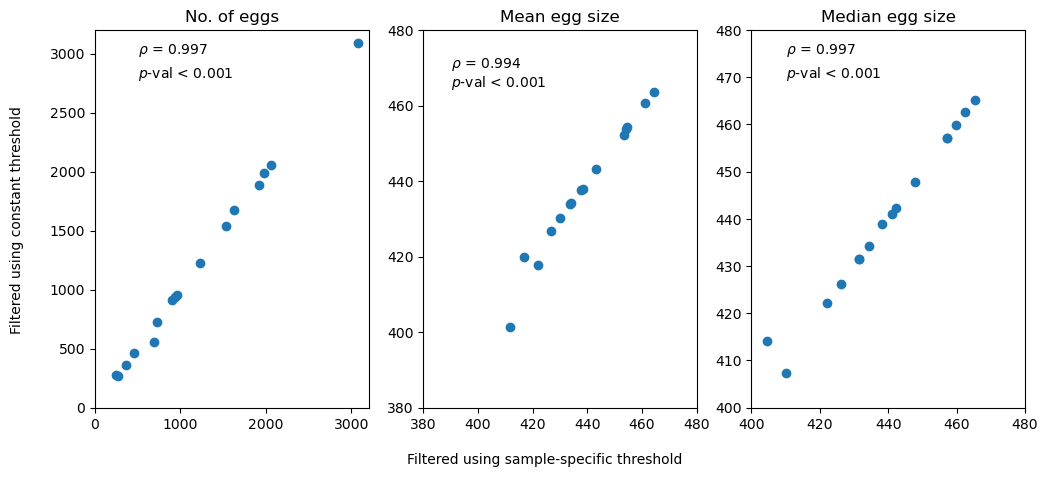

In [55]:
fig , ax = plt.subplots(nrows=1, ncols=3,sharex=True, sharey=True,figsize=(12,5),dpi=100, facecolor='w', edgecolor='k')    
ax=plt.subplot(1,3,1)
plt.title('No. of eggs')
plt.plot(num_egg_ss,num_egg_ave, marker = 'o', linestyle = '')
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(num_egg_ss,num_egg_ave)[0],3)), xy=(500,3000))
plt.annotate('$\it{p}$-val < 0.001', xy=(500,2800))
plt.xlim(0,3200)
plt.ylim(0,3200)
ax=plt.subplot(1,3,2)
plt.title('Mean egg size')
plt.plot(mean_egg_ss,mean_egg_ave, marker = 'o', linestyle = '')
plt.xlim(380,480)
plt.ylim(380,480)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(mean_egg_ss,mean_egg_ave)[0],3)), xy=(390,470))
plt.annotate('$\it{p}$-val < 0.001', xy=(390,465))
ax=plt.subplot(1,3,3)
plt.title('Median egg size')
plt.plot(median_egg_ss, median_egg_ave, marker = 'o', linestyle = '')
plt.xlim(400,480)
plt.ylim(400,480)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(median_egg_ss, median_egg_ave)[0],3)), xy=(410,475))
plt.annotate('$\it{p}$-val < 0.001', xy=(410,470))
fig.text(0.5, 0.02, 'Filtered using sample-specific threshold', ha='center', va='center')
fig.text(0.06, 0.5, 'Filtered using constant threshold', ha='center', va='center', rotation='vertical')
plt.savefig('../plots/final_plots/stats_egg_particles.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/stats_egg_particles.svg', dpi=100,format='svg', bbox_inches = 'tight')



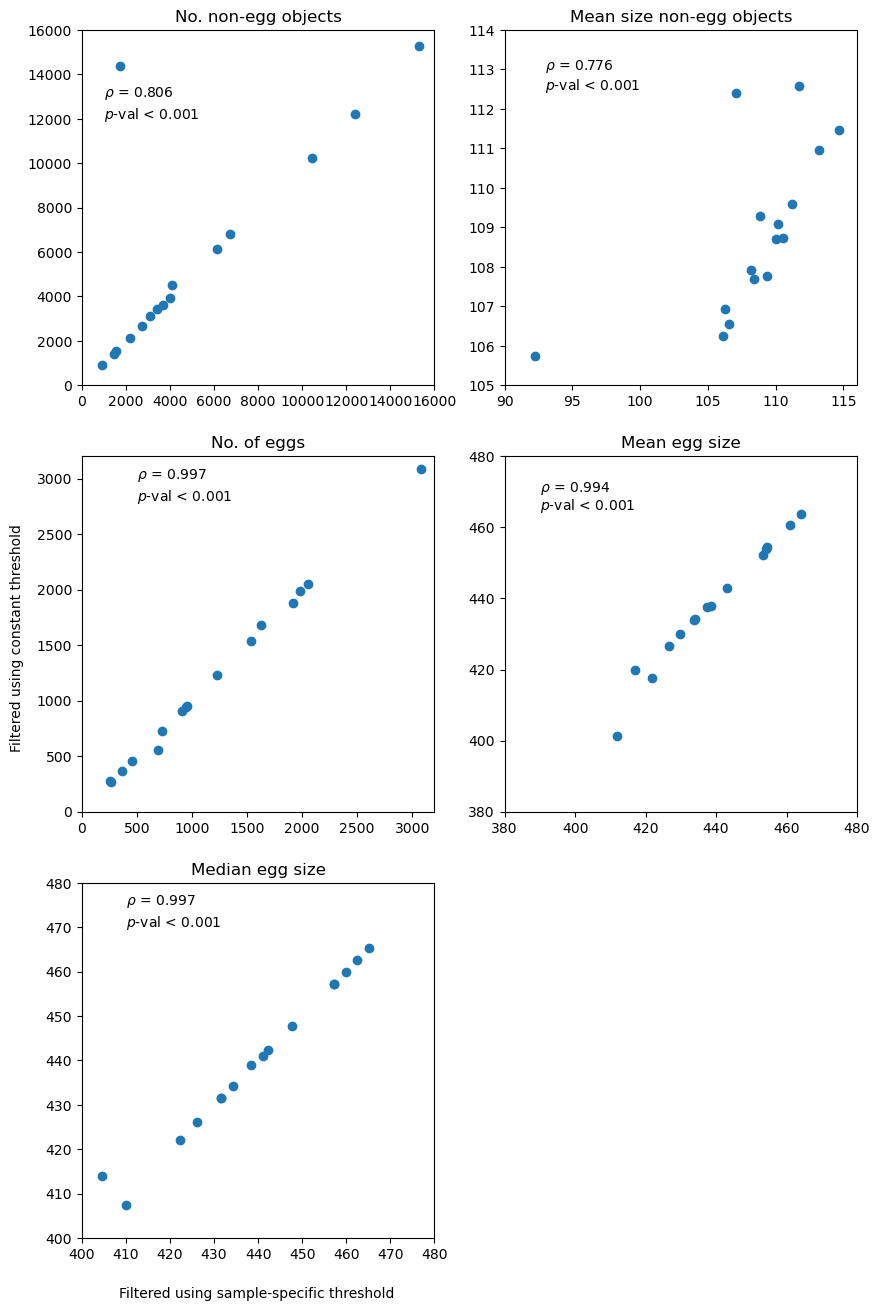

In [56]:
fig , ax = plt.subplots(nrows=3, ncols=2,sharex=True, sharey=True,figsize=(10,16),dpi=100, facecolor='w', edgecolor='k')    
ax=plt.subplot(3,2,1)
plt.title('No. non-egg objects')
plt.plot(num_nonegg_ss, num_nonegg_ave, marker = 'o', linestyle = '')
plt.xlim(0,16000)
plt.ylim(0,16000)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(num_nonegg_ss, num_nonegg_ave)[0],3)), xy=(1000,13000))
plt.annotate('$\it{p}$-val < 0.001', xy=(1000,12000))

ax=plt.subplot(3,2,2)
plt.title('Mean size non-egg objects')
plt.plot(mean_nonegg_ss, mean_nonegg_ave, marker = 'o', linestyle = '')
plt.xlim(90,116)
plt.ylim(105,114)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(mean_nonegg_ss, mean_nonegg_ave)[0],3)), xy=(93,113))
plt.annotate('$\it{p}$-val < 0.001', xy=(93,112.5))

ax=plt.subplot(3,2,3)
plt.title('No. of eggs')
plt.plot(num_egg_ss,num_egg_ave, marker = 'o', linestyle = '')
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(num_egg_ss,num_egg_ave)[0],3)), xy=(500,3000))
plt.annotate('$\it{p}$-val < 0.001', xy=(500,2800))
plt.xlim(0,3200)
plt.ylim(0,3200)

ax=plt.subplot(3,2,4)
plt.title('Mean egg size')
plt.plot(mean_egg_ss,mean_egg_ave, marker = 'o', linestyle = '')
plt.xlim(380,480)
plt.ylim(380,480)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(mean_egg_ss,mean_egg_ave)[0],3)), xy=(390,470))
plt.annotate('$\it{p}$-val < 0.001', xy=(390,465))

ax=plt.subplot(3,2,5)
plt.title('Median egg size')
plt.plot(median_egg_ss, median_egg_ave, marker = 'o', linestyle = '')
plt.xlim(400,480)
plt.ylim(400,480)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(median_egg_ss, median_egg_ave)[0],3)), xy=(410,475))
plt.annotate('$\it{p}$-val < 0.001', xy=(410,470))

ax=plt.subplot(3,2,6)
ax.set_visible(False)

fig.text(0.3, 0.09, 'Filtered using sample-specific threshold', ha='center', va='center')
fig.text(0.06, 0.5, 'Filtered using constant threshold', ha='center', va='center', rotation='vertical')

plt.savefig('../plots/final_plots/FigS4.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/FigS4.svg', dpi=100,format='svg', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/FigS4.pdf', dpi=100,format='pdf', bbox_inches = 'tight')



### We save the summary statistics of egg size distributions filetered using sample-specific and average threshold in a file.

In [57]:
sam_name = ['Dsim1','Dsim4','Dsim5','Dsim11','Dsim75','Dsim90','Dsim91','Dsim146','Dsim166','Dsim185','Dsim196','Dsim237',
       'Lausanne5','Dere01','Dsan01','Dmau151']

#compute summary statistics for datasets by filtering them using average of sample specific threhsold
num_egg1, num_nonegg1, num_misegg1,mode_nonegg1, mean_nonegg1, median_nonegg1,mode_egg1, mean_egg1, median_egg1,mean_misegg1, median_misegg1 = compute_summary_stat(sam_rawdata,sam_flt,sam_flt4)

df_ss = pd.DataFrame(list(zip(sam_name, sam_thre2,num_egg1, num_nonegg1, num_misegg1,mode_nonegg1, mean_nonegg1, 
                              median_nonegg1,mode_egg1, mean_egg1, median_egg1,mean_misegg1, median_misegg1)),
        columns =['sample','threshold','num_egg', 'num_nonegg', 'num_misaligned_egg', 'mode_nonegg', 'mean_nonegg',
                  'median_nonegg', 'mode_egg', 'mean_egg', 'median_egg', 'mean_misaligned_egg', 'median_misaligned_egg'])


In [58]:
#write the result in table
OutputFile = open('../plots/final_plots/summary_stats.txt','w')
df_ss.to_csv(OutputFile, header=True, sep='\t', float_format = '%.3f')
OutputFile.flush()

#### The above plots show that the choice of filtering threshold (sample-specific or average) doesn't affect the median egg size much. So we will use sample-specific threshold for filtering.

## 4.5 Compute the measurement speed

### We first compute the measurement speed for unfiltered datasets.

In [59]:
#compute the number of sorted eggs, total number of eggs in sorted gates, sort recovery and sort time
all_data_raw_speed = [compute_speed(i) for i in [Dsim001,Dsim004,Dsim5_1,Dsim5_2, Dsim11,Dsim75,Dsim90,Dsim91,Dsim146,
               Dsim166,Dsim185,Dsim196,Dsim237_1,Dsim237_2,Lausanne5,Dere01,Dsan01,Dmau151_1,Dmau151_2]]

### We then compute the measurement speed for filtered datasets after each filtering step

In [60]:
#compute the number of sorted eggs, total number of eggs in sorted gates, sort recovery and sort time
all_data_flt_speed = [compute_speed(i) for i in [Dsim001_flt,Dsim004_flt, Dsim11_flt,Dsim75_flt,Dsim90_flt,
                    Dsim91_flt,Dsim146_flt,Dsim166_flt,Dsim185_flt,Dsim196_flt,Lausanne5_flt,Dere01_flt,Dsan01_flt]]

all_data_flt2_speed = [compute_speed(i) for i in [Dsim001_flt2,Dsim004_flt2, Dsim11_flt2,Dsim75_flt2,Dsim90_flt2,
                    Dsim91_flt2,Dsim146_flt2,Dsim166_flt2,Dsim185_flt2,Dsim196_flt2,Lausanne5_flt2,Dere01_flt2,Dsan01_flt2]]

all_data_flt3_speed = [compute_speed(i) for i in [Dsim001_flt3,Dsim004_flt3, Dsim11_flt3,Dsim75_flt3,Dsim90_flt3,
                    Dsim91_flt3,Dsim146_flt3,Dsim166_flt3,Dsim185_flt3,Dsim196_flt3,Lausanne5_flt3,Dere01_flt3,Dsan01_flt3]]

all_data_flt4_speed = [compute_speed(i) for i in [Dsim001_flt4,Dsim004_flt4, Dsim11_flt4,Dsim75_flt4,Dsim90_flt4,
                    Dsim91_flt4,Dsim146_flt4,Dsim166_flt4,Dsim185_flt4,Dsim196_flt4,Lausanne5_flt4,Dere01_flt4,Dsan01_flt4]]



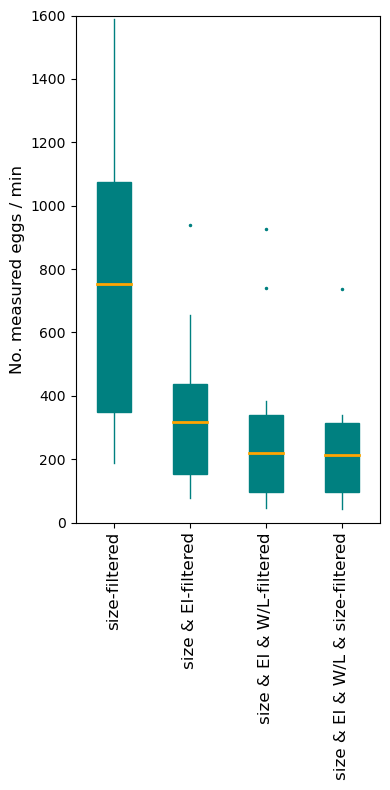

In [61]:
fig , ax = plt.subplots(sharex=True, sharey=True,figsize=(4,8),dpi=100, facecolor='w', edgecolor='k')    
set_color_flier('teal')
box=ax.boxplot([[item[2] for item in all_data_flt_speed], [item[2] for item in all_data_flt2_speed],
               [item[2] for item in all_data_flt3_speed], [item[2] for item in all_data_flt4_speed]], 
               medianprops = dict(color="orange",linewidth=2),vert = True,showcaps = False, 
               showfliers = True, patch_artist=True, flierprops=set_color_flier('teal'))
set_color_box('teal')
plt.ylabel('No. measured eggs / min',fontsize=12)
plt.xticks(range(1,5),['size-filtered','size & EI-filtered','size & EI & W/L-filtered','size & EI & W/L & size-filtered'],
           fontsize=12, va='top', rotation=90)
plt.ylim(0,1600)
fig.tight_layout()
plt.savefig('../plots/final_plots/measurement_speed.jpeg', dpi=100,format='jpeg', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/measurement_speed.svg', dpi=100,format='svg', bbox_inches = 'tight')


In [62]:
#statistics for unfiltered data
#item[2] shows number of eggs / minute
print(min([item[2] for item in all_data_raw_speed]))
print(max([item[2] for item in all_data_raw_speed]))
print(np.mean([item[2] for item in all_data_raw_speed]))
print(np.var([item[2] for item in all_data_raw_speed]))
print(np.std([item[2] for item in all_data_raw_speed]))

469.09590218294926
4720.248569440319
1680.6177111544453
1362179.3653584376
1167.1244001212715


In [63]:
#statistics for filtered data
#item[2] shows number of eggs / minute
print(min([item[2] for item in all_data_flt_speed]))
print(max([item[2] for item in all_data_flt_speed]))
print(np.mean([item[2] for item in all_data_flt_speed]))
print(np.var([item[2] for item in all_data_flt_speed]))
print(np.std([item[2] for item in all_data_flt_speed]))

187.46472117471532
2571.895661697793
961.7596279949123
568417.7206096463
753.934825173666


In [64]:
#statistics for filtered data
#item[2] shows number of eggs / minute
print(min([item[2] for item in all_data_flt2_speed]))
print(max([item[2] for item in all_data_flt2_speed]))
print(np.mean([item[2] for item in all_data_flt2_speed]))
print(np.var([item[2] for item in all_data_flt2_speed]))
print(np.std([item[2] for item in all_data_flt2_speed]))

76.74150518746227
1712.4857279359965
441.90882871842325
187582.71344459162
433.1082006203434


In [65]:
#statistics for filtered data
#item[2] shows number of eggs / minute
print(min([item[2] for item in all_data_flt3_speed]))
print(max([item[2] for item in all_data_flt3_speed]))
print(np.mean([item[2] for item in all_data_flt3_speed]))
print(np.var([item[2] for item in all_data_flt3_speed]))
print(np.std([item[2] for item in all_data_flt3_speed]))

47.07030329575286
926.8625888399174
292.41213484959525
64244.3678877853
253.46472710770882


In [66]:
#statistics for filtered data
#item[2] shows number of eggs / minute
print(min([item[2] for item in all_data_flt4_speed]))
print(max([item[2] for item in all_data_flt4_speed]))
print(np.mean([item[2] for item in all_data_flt4_speed]))
print(np.var([item[2] for item in all_data_flt4_speed]))
print(np.std([item[2] for item in all_data_flt4_speed]))

42.19100712746747
738.4040751093899
238.21548750494514
30503.63762978609
174.65290615900466


Text(0, 0.5, 'No. non-egg particles')

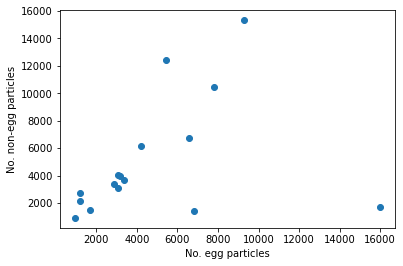

In [71]:
plt.scatter([i+ss_all[2][ind] for ind,i in enumerate(ss_all[0])] , ss_all[1])
plt.xlabel('No. egg particles')
plt.ylabel('No. non-egg particles')

SpearmanrResult(correlation=0.5058823529411764, pvalue=0.045581616123940336)

SpearmanrResult(correlation=0.4823529411764706, pvalue=0.058458976774719576)